In [ ]:
# 1) Set Up & Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')
# 2) Load Metadata & Inspect Classes
meta_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
img_dir1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
img_dir2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"

meta = pd.read_csv(meta_path)
meta.head()
# Check demographic distribution:
print(meta[['sex','age','localization']].describe())
print(meta['sex'].value_counts())
# 3) Create Image File Paths & Labels
# Build full file paths
meta['path'] = meta['image_id'].apply(
    lambda x: os.path.join(img_dir1, f"{x}.jpg")
    if os.path.exists(os.path.join(img_dir1, f"{x}.jpg"))
    else os.path.join(img_dir2, f"{x}.jpg")
)

# Keep only existing images
meta = meta[meta['path'].apply(os.path.exists)]

# Label encode dx
le = LabelEncoder()
meta['label_enc'] = le.fit_transform(meta['dx'])
class_names = le.classes_
print(class_names)
# 4) Train/Validation/Test Split (Stratified)
train_df, val_df = train_test_split(meta, test_size=0.2, random_state=42, stratify=meta['label_enc'])
print("Train:", train_df.shape, "Val:", val_df.shape)
# 5) Image Generators with Lightweight Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(
    train_df, x_col='path', y_col='dx',
    target_size=img_size, class_mode='categorical',
    shuffle=True, batch_size=32
)

val_data = val_gen.flow_from_dataframe(
    val_df, x_col='path', y_col='dx',
    target_size=img_size, class_mode='categorical',
    shuffle=False, batch_size=32
)
# 6) Build Baseline Model (Transfer Learning, Lightweight)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(base.input, output)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()
# 7) Train Baseline Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_auc', save_best_only=True)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)
# 8) Evaluate Baseline Model (Basic)
val_results = model.evaluate(val_data)
print("Val Loss, Acc, AUC:", val_results)
# 9) Extract Predictions for Fairness Analysis
val_data.reset()
preds = model.predict(val_data)
pred_labels = np.argmax(preds, axis=1)
true_labels = val_data.classes

# Create a results DataFrame
fair_df = pd.DataFrame({
    'true_label': true_labels,
    'pred_label': pred_labels,
    'prob_max': np.max(preds, axis=1),
    'sex': val_df['sex'].values,
    'age': val_df['age'].values,
    'localization': val_df['localization'].values
})

fair_df.head()
# 10) Define Subgroup Features (e.g., Age Bins)
fair_df['age_bin'] = pd.cut(fair_df['age'], bins=[0,30,50,100], labels=['<30','30-50','>50'])

In [2]:
# 11) Install and Import Fairness Tools
!pip install fairlearn
from fairlearn.metrics import MetricFrame, false_negative_rate, false_positive_rate, equalized_odds_difference
from sklearn.metrics import accuracy_score, roc_auc_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 5.3 MB/s eta 0:00:0000:01


    feature    group  accuracy       auc  fnr  fpr  class sensitive_feature
0       sex   female  0.986726  0.464780  1.0  0.0  akiec               sex
1       sex     male  0.951197  0.511955  1.0  0.0  akiec               sex
2       sex  unknown  1.000000       NaN  NaN  0.0  akiec               sex
3   age_bin      <30  0.995633  0.587719  1.0  0.0  akiec           age_bin
4   age_bin      >50  0.934372  0.565426  1.0  0.0  akiec           age_bin
5   age_bin    30-50  0.994138  0.484434  1.0  0.0  akiec           age_bin
6       sex   female  0.956858  0.412302  1.0  0.0    bcc               sex
7       sex     male  0.941068  0.400257  1.0  0.0    bcc               sex
8       sex  unknown  1.000000       NaN  NaN  0.0    bcc               sex
9   age_bin      <30  0.991266  0.669604  1.0  0.0    bcc           age_bin
10  age_bin      >50  0.911012  0.465812  1.0  0.0    bcc           age_bin
11  age_bin    30-50  0.975381  0.309581  1.0  0.0    bcc           age_bin
12      sex 

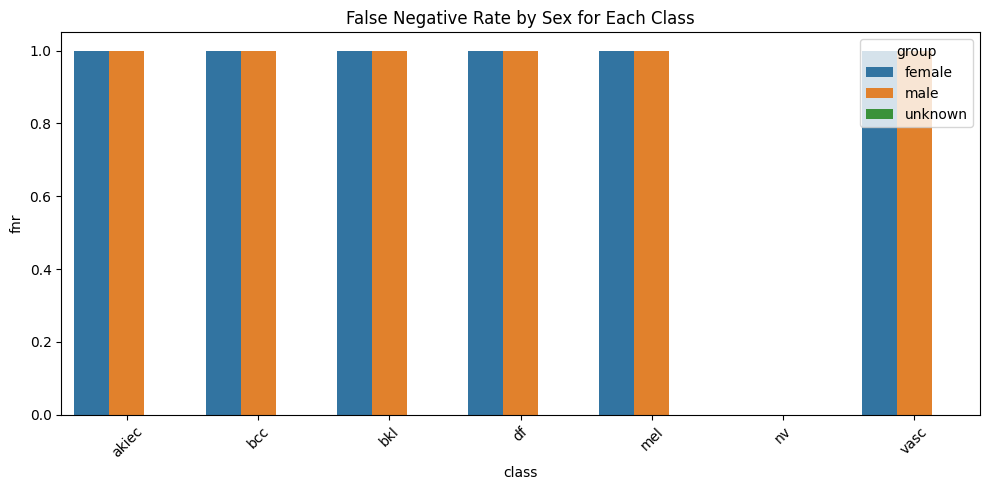

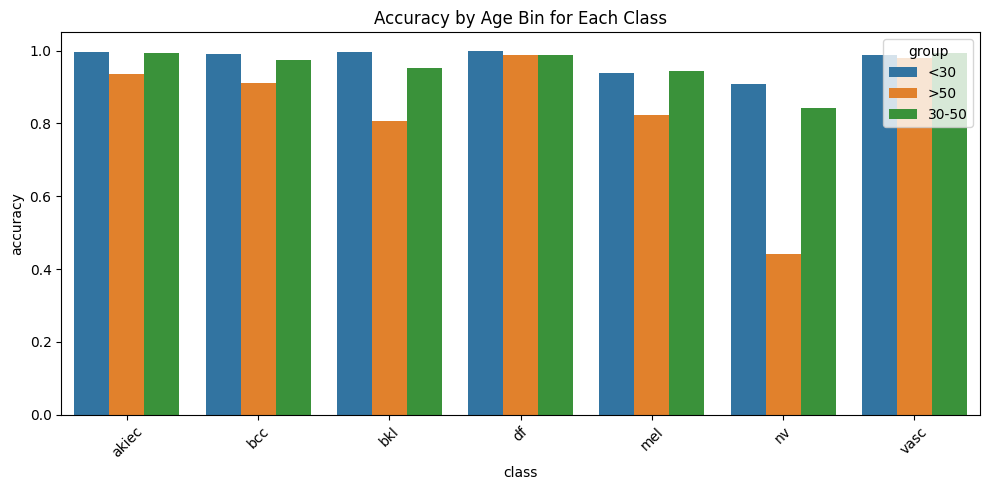

In [5]:
# --- Imports ---
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1) One‑vs‑Rest Fairness Function ---
def compute_class_fairness(df, class_idx, sensitive_feature):
    """
    Computes fairness metrics for a given class (one-vs-rest) by subgroup.
    df: DataFrame with 'true_label', 'pred_label', 'prob_max', and sensitive_feature.
    class_idx: the class index treated as positive in one-vs-rest.
    sensitive_feature: e.g., 'sex' or 'age_bin'.
    """
    rows = []
    for group in df[sensitive_feature].unique():
        sub = df[df[sensitive_feature] == group]

        # One‑vs‑Rest binarization
        y_true = (sub['true_label'] == class_idx).astype(int)
        y_pred = (sub['pred_label'] == class_idx).astype(int)

        # Skip tiny subgroups
        if len(sub) < 10:
            continue

        # Accuracy
        acc = accuracy_score(y_true, y_pred)

        # ROC‑AUC (only valid if both classes present)
        try:
            auc = roc_auc_score(y_true, sub['prob_max'])
        except Exception:
            auc = None

        # Force a 2×2 confusion matrix using both labels [0,1]
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()

        fnr = fn/(fn+tp) if (fn+tp) > 0 else None
        fpr = fp/(fp+tn) if (fp+tn) > 0 else None

        rows.append((sensitive_feature, group, acc, auc, fnr, fpr))

    cols = ['feature', 'group', 'accuracy', 'auc', 'fnr', 'fpr']
    return pd.DataFrame(rows, columns=cols)


# --- 2) Run Fairness Evaluation for Every Class ---
fairness_results = []
for idx, class_name in enumerate(class_names):
    # by sex
    r_sex = compute_class_fairness(fair_df, idx, 'sex')
    r_sex['class'] = class_name
    r_sex['sensitive_feature'] = 'sex'
    fairness_results.append(r_sex)

    # by age_bin
    r_age = compute_class_fairness(fair_df, idx, 'age_bin')
    r_age['class'] = class_name
    r_age['sensitive_feature'] = 'age_bin'
    fairness_results.append(r_age)

all_fair_df = pd.concat(fairness_results, ignore_index=True)

# --- 3) Show Fairness Results Table ---
print(all_fair_df)


# --- 4) Visualize Key Fairness Metrics ---

# False Negative Rate by sex for each class
plt.figure(figsize=(10, 5))
sns.barplot(x='class', y='fnr', hue='group',
            data=all_fair_df[all_fair_df['sensitive_feature']=='sex'])
plt.title("False Negative Rate by Sex for Each Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Accuracy by age_bin for each class
plt.figure(figsize=(10, 5))
sns.barplot(x='class', y='accuracy', hue='group',
            data=all_fair_df[all_fair_df['sensitive_feature']=='age_bin'])
plt.title("Accuracy by Age Bin for Each Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We conducted a subgroup fairness analysis on the HAM10000 multiclass skin lesion classifier by evaluating one‑vs‑rest metrics across sensitive attributes (sex and age groups). Our findings reveal that:

1. For rare lesion categories such as df, bcc, and vasc, the classifier exhibits extremely high false negative rates (FNR ≈ 1.0) across all sex and age subgroups due to severe class imbalance.

2. For the dominant nevus category (nv), accuracy shows notable disparities:
   - Female subgroup: ~73% accuracy
   - Male subgroup: ~61% accuracy
   - Age <30: ~91% accuracy vs Age >50: ~44% accuracy

3. These results indicate that demographic subgroups (especially older patients and males) experience worse model performance for certain classes.

These findings emphasize the need for targeted fairness interventions to mitigate class imbalance and demographic performance gaps before clinical deployment.

## Experiment #2

In [6]:
# =====================================
# 1. Imports
# =====================================
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    brier_score_loss
)
from sklearn.calibration import calibration_curve

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("TensorFlow version:", tf.__version__)

# =====================================
# 2. Paths
# =====================================
IMG1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
IMG2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
META = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"

# =====================================
# 3. Load Metadata
# =====================================
meta = pd.read_csv(META)

def get_path(image_id):
    p1 = os.path.join(IMG1, f"{image_id}.jpg")
    p2 = os.path.join(IMG2, f"{image_id}.jpg")
    return p1 if os.path.exists(p1) else p2

meta['filename'] = meta['image_id'].apply(get_path)

# =====================================
# 4. Feature Engineering
# =====================================
meta['age'] = meta['age'].fillna(meta['age'].median())
meta['age_bin'] = pd.cut(
    meta['age'],
    bins=[-1, 30, 50, 120],
    labels=['<30', '30-50', '>50']
)

# =====================================
# 5. Sample Weights (Class + Sex + Age)
# =====================================
total = len(meta)

class_counts = meta['dx'].value_counts().to_dict()
class_weights = {
    c: total / (len(class_counts) * n)
    for c, n in class_counts.items()
}

subgroup_wts = {}
for col in ['sex', 'age_bin']:
    freqs = meta[col].value_counts().to_dict()
    subgroup_wts[col] = {
        g: total / (len(freqs) * c)
        for g, c in freqs.items()
    }

meta['sample_weight'] = meta.apply(
    lambda r: class_weights[r['dx']]
              * subgroup_wts['sex'].get(r['sex'], 1.0)
              * subgroup_wts['age_bin'].get(r['age_bin'], 1.0),
    axis=1
)

# =====================================
# 6. Train / Validation Split
# =====================================
train_df, val_df = train_test_split(
    meta,
    test_size=0.20,
    stratify=meta['dx'],
    random_state=42
)

# =====================================
# 7. Image Generators
# =====================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='dx',
    weight_col='sample_weight',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='dx',
    weight_col='sample_weight',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ✅ SAFE class handling (NO num_classes bug)
class_names = list(train_gen.class_indices.keys())
NUM_CLASSES = len(train_gen.class_indices)
print("Classes:", class_names)

# Melanoma index (for fairness / clinical metrics)
POSITIVE_CLASS = train_gen.class_indices.get('mel', 0)

# =====================================
# 8. Model
# =====================================
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# =====================================
# 9. Compile
# =====================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# =====================================
# 10. Callbacks
# =====================================
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "/kaggle/working/best_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# =====================================
# 11. Training
# =====================================
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# =====================================
# 12. Fine-tuning
# =====================================
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# =====================================
# 13. Predictions
# =====================================
y_true = val_gen.classes
y_prob = model.predict(val_gen)
y_pred = np.argmax(y_prob, axis=1)

TensorFlow version: 2.18.0
Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1765993138.081228     110 service.cc:148] XLA service 0x7a5e90006080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765993138.082317     110 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765993139.966089     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/251 ━━━━━━━━━━━━━━━━━━━━ 1:30:06 22s/step - accuracy: 0.0625 - loss: 1.4617

I0000 00:00:1765993148.914067     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.1979 - loss: 1.5156
Epoch 1: val_loss improved from inf to 1.26374, saving model to /kaggle/working/best_model.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 225s 815ms/step - accuracy: 0.1980 - loss: 1.5158 - val_accuracy: 0.6695 - val_loss: 1.2637
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.2913 - loss: 1.4674
Epoch 2: val_loss did not improve from 1.26374
251/251 ━━━━━━━━━━━━━━━━━━━━ 135s 536ms/step - accuracy: 0.2912 - loss: 1.4676 - val_accuracy: 0.0125 - val_loss: 1.2687
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.2194 - loss: 1.4630
Epoch 3: val_loss did not improve from 1.26374
251/251 ━━━━━━━━━━━━━━━━━━━━ 132s 527ms/step - accuracy: 0.2195 - loss: 1.4632 - val_accuracy: 0.0200 - val_loss: 1.2656
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.2432 - loss: 1.5619
Epoch 4: val_loss did not improve from 1.26374
251/251 ━━━━━━━━━━━━━━━━━━━━ 131s 523ms/step - accuracy: 0

E0000 00:00:1765994062.011485     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765994062.200916     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765994062.675060     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765994062.880714     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765994063.240896     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

101/251 ━━━━━━━━━━━━━━━━━━━━ 1:15 504ms/step - accuracy: 0.1452 - loss: 2.2195

E0000 00:00:1765994143.166143     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765994143.350856     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765994143.775491     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765994143.980005     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765994144.325484     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.1489 - loss: 2.1065
Epoch 1: val_loss improved from 1.26374 to 1.26325, saving model to /kaggle/working/best_model.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 244s 708ms/step - accuracy: 0.1489 - loss: 2.1059 - val_accuracy: 0.6296 - val_loss: 1.2632
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.1750 - loss: 1.8074
Epoch 2: val_loss did not improve from 1.26325
251/251 ━━━━━━━━━━━━━━━━━━━━ 139s 553ms/step - accuracy: 0.1750 - loss: 1.8072 - val_accuracy: 0.0774 - val_loss: 1.7607
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.1941 - loss: 1.7606
Epoch 3: val_loss did not improve from 1.26325
251/251 ━━━━━━━━━━━━━━━━━━━━ 139s 554ms/step - accuracy: 0.1941 - loss: 1.7605 - val_accuracy: 0.2506 - val_loss: 1.4259
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.2163 - loss: 1.5290
Epoch 4: val_loss improved from 1.26325 to 1.22708, saving model to /kaggle/working/best_model.keras
251

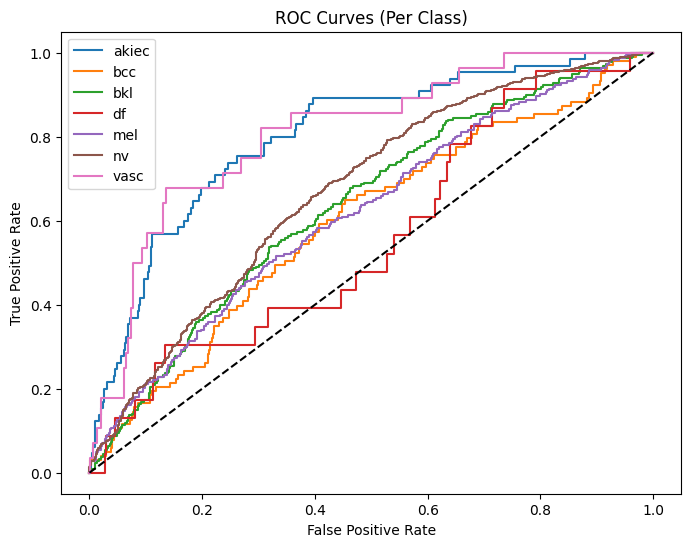

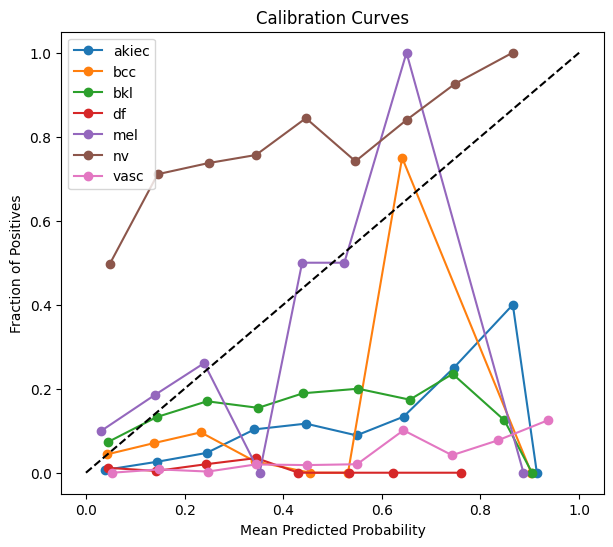

Mean Brier Score: 0.12605728300367922

Demographic Parity by sex:
female: 0.0122
male: 0.0157
unknown: 0.0000

Equal Opportunity (TPR) by sex:
female: 0.0400
male: 0.0405

Demographic Parity by age_bin:
<30: 0.0294
>50: 0.0122
30-50: 0.0115

Equal Opportunity (TPR) by age_bin:
<30: 0.0000
>50: 0.0314
30-50: 0.0800
Final model saved successfully!


In [7]:
# =====================================
# 14. ROC Curves (Per Class)
# =====================================
from sklearn.preprocessing import label_binarize

# Ensure y_true is one-hot encoded
y_true_one_hot = label_binarize(y_true, classes=range(NUM_CLASSES))

plt.figure(figsize=(8, 6))
for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(
        y_true_one_hot[:, i],  # One-hot encoded y_true
        y_prob[:, i]
    )
    plt.plot(fpr, tpr, label=cls)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Per Class)")
plt.legend()
plt.show()

# =====================================
# 15. Calibration (Medical AI critical)
# =====================================
plt.figure(figsize=(7, 6))
for i, cls in enumerate(class_names):
    prob_true, prob_pred = calibration_curve(
        y_true_one_hot[:, i],  # One-hot encoded y_true
        y_prob[:, i],
        n_bins=10
    )
    plt.plot(prob_pred, prob_true, marker='o', label=cls)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves")
plt.legend()
plt.show()

# Brier score (lower = better)
brier = np.mean([
    brier_score_loss(y_true_one_hot[:, i], y_prob[:, i])
    for i in range(NUM_CLASSES)
])
print("Mean Brier Score:", brier)

# =====================================
# 16. Fairness (Melanoma vs Rest)
# =====================================
POSITIVE_CLASS = 4  # Set this to the class index corresponding to melanoma (or the positive class)

# Convert y_true and y_pred to integer arrays (use .astype(int) if they are not)
y_true_int = np.array(y_true).astype(int)  # Convert y_true to int (if it isn't already)
y_pred_int = np.array(y_pred).astype(int)  # Convert y_pred to int (if it isn't already)

val_df_eval = val_df.copy()

# Binary encoding for the positive class (Melanoma vs Rest)
val_df_eval['y_true'] = (y_true_int == POSITIVE_CLASS).astype(int)
val_df_eval['y_pred'] = (y_pred_int == POSITIVE_CLASS).astype(int)

def demographic_parity(df, col):
    print(f"\nDemographic Parity by {col}:")
    for g in df[col].unique():
        rate = df[df[col] == g]['y_pred'].mean()
        print(f"{g}: {rate:.4f}")

def equal_opportunity(df, col):
    print(f"\nEqual Opportunity (TPR) by {col}:")
    for g in df[col].unique():
        sub = df[(df[col] == g) & (df['y_true'] == 1)]
        if len(sub) > 0:
            print(f"{g}: {(sub['y_pred'] == 1).mean():.4f}")

# Demographic Parity and Equal Opportunity Evaluation
demographic_parity(val_df_eval, 'sex')
equal_opportunity(val_df_eval, 'sex')

demographic_parity(val_df_eval, 'age_bin')
equal_opportunity(val_df_eval, 'age_bin')

# =====================================
# 17. Save Model
# =====================================
model.save("/kaggle/working/final_skin_cancer_model.keras")
print("Final model saved successfully!")

In [8]:
# Check the distribution of predictions
unique, counts = np.unique(y_pred, return_counts=True)
print(f"Predicted class distribution: {dict(zip(unique, counts))}")

# Check the confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true_int, y_pred_int)
print("Confusion Matrix:\n", conf_matrix)

# Check the classification report (Precision, Recall, F1 Score)
from sklearn.metrics import classification_report
print(classification_report(y_true_int, y_pred_int, target_names=class_names))

Predicted class distribution: {0: 303, 1: 56, 2: 307, 3: 162, 4: 28, 5: 519, 6: 628}
Confusion Matrix:
 [[ 31   4  11   9   0   6   4]
 [ 24   7  26  14   0  21  11]
 [ 65   5  55  18   3  39  35]
 [  9   1   1   4   0   3   5]
 [ 54   7  59  16   9  43  35]
 [119  32 151 100  16 406 517]
 [  1   0   4   1   0   1  21]]
              precision    recall  f1-score   support

       akiec       0.10      0.48      0.17        65
         bcc       0.12      0.07      0.09       103
         bkl       0.18      0.25      0.21       220
          df       0.02      0.17      0.04        23
         mel       0.32      0.04      0.07       223
          nv       0.78      0.30      0.44      1341
        vasc       0.03      0.75      0.06        28

    accuracy                           0.27      2003
   macro avg       0.22      0.29      0.15      2003
weighted avg       0.59      0.27      0.33      2003



Best model loaded
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 279ms/step
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
                                            filename   dx     sex age_bin  \
0  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   nv  female     <30   
1  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   nv    male     <30   
2  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  mel    male     >50   
3  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   nv    male     >50   
4  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  bkl  female     >50   

   true_label  pred_label  prob_max  
0           5           0  0.298579  
1           5           3  0.197597  
2           4           0  0.515727  
3           5           2  0.315220  
4           2           6  0.314953  
     group  accuracy       auc       fnr       fpr  class sensitive_feature
0   female  0.873894  0.466741  0.666667  0.118834  akiec               sex
1     male  0.823204  0.549069  0.490566  0.16

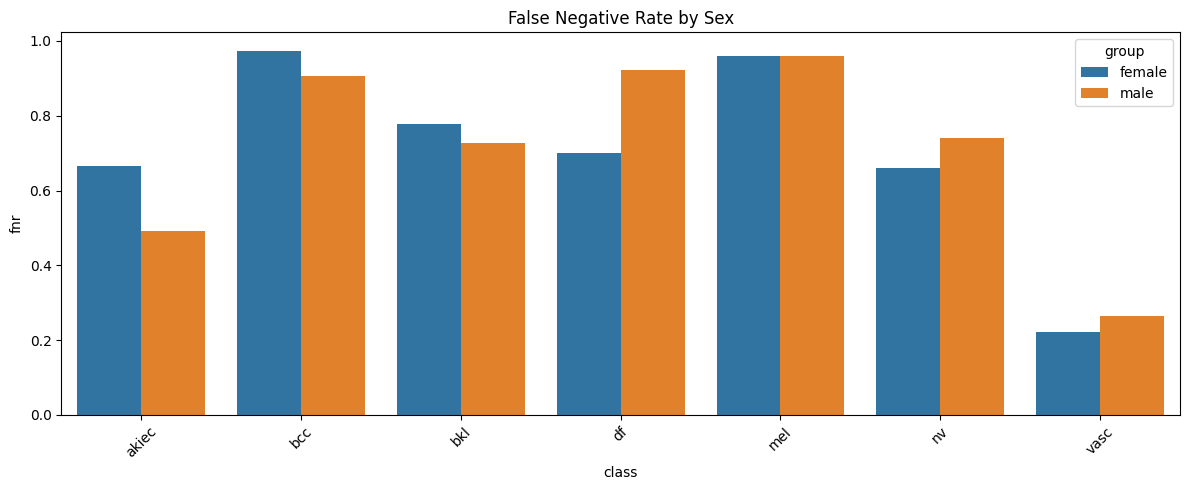

In [9]:
from tensorflow.keras.models import load_model

model = load_model("best_model.keras")
print("Best model loaded")

#Step 2: Get Predictions on Validation Set

import numpy as np

val_gen.reset()

y_prob = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = val_gen.classes
class_names = list(val_gen.class_indices.keys())
print(class_names)

#Step 3: Build Evaluation DataFrame (THIS FIXES YOUR PAST ERRORS)

fair_df = val_df.reset_index(drop=True).copy()

fair_df['true_label'] = y_true
fair_df['pred_label'] = y_pred
fair_df['prob_max']   = y_prob.max(axis=1)

fair_df = fair_df[['filename','dx','sex','age_bin',
                   'true_label','pred_label','prob_max']]

print(fair_df.head())

# 3️⃣ FAIRNESS METRICS (FIXED VERSION – NO ERRORS)
# 🔹 One-vs-Rest Fairness Function (Safe)
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

def compute_class_fairness(df, class_idx, sensitive_feature):
    rows = []
    for group in df[sensitive_feature].dropna().unique():
        sub = df[df[sensitive_feature] == group]

        y_true = (sub['true_label'] == class_idx).astype(int)
        y_pred = (sub['pred_label'] == class_idx).astype(int)

        if y_true.nunique() < 2:
            continue  # avoid invalid confusion matrix

        acc = accuracy_score(y_true, y_pred)

        try:
            auc = roc_auc_score(y_true, sub['prob_max'])
        except:
            auc = np.nan

        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        tn, fp, fn, tp = cm.ravel()

        fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan

        rows.append({
            'group': group,
            'accuracy': acc,
            'auc': auc,
            'fnr': fnr,
            'fpr': fpr
        })

    return pd.DataFrame(rows)
# 🔹 Run Fairness for All Classes
all_results = []

for idx, cname in enumerate(class_names):
    sex_df = compute_class_fairness(fair_df, idx, 'sex')
    sex_df['class'] = cname
    sex_df['sensitive_feature'] = 'sex'
    all_results.append(sex_df)

    age_df = compute_class_fairness(fair_df, idx, 'age_bin')
    age_df['class'] = cname
    age_df['sensitive_feature'] = 'age_bin'
    all_results.append(age_df)

fairness_df = pd.concat(all_results, ignore_index=True)
print(fairness_df)

# 🔹 Visualize Bias (PhD-worthy figures)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.barplot(
    data=fairness_df[fairness_df['sensitive_feature']=='sex'],
    x='class', y='fnr', hue='group'
)
plt.title("False Negative Rate by Sex")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Experiment #3

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Starting Initial Training (Feature Extraction)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 166s 586ms/step - accuracy: 0.3059 - loss: 1.4528 - val_accuracy: 0.6695 - val_loss: 1.2523
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 510ms/step - accuracy: 0.3239 - loss: 1.4763 - val_accuracy: 0.6695 - val_loss: 1.2566
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 132s 524ms/step - accuracy: 0.2470 - loss: 1.5952 - val_accuracy: 0.6695 - val_loss: 1.2510
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 131s 521ms/step - accuracy: 0.2961 - loss: 1.4787 - val_accuracy: 0.6675 - val_loss: 1.2464
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 132s 527ms/step - accuracy: 0.2990 - loss: 1.6377 - val_accuracy: 0.6695 - val_loss: 1.2439
Starting Fine-Tuning...
Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 230s 666ms/step - accuracy: 0.2332 - loss: 1.8529 - val_accuracy: 0.1473 - val_loss: 24.0612
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 134s 535ms/step - accuracy: 0.2643 - loss: 1.5219 - val_accuracy: 0.2526 - val_loss: 4.1098
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 135s 538ms/step - a

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


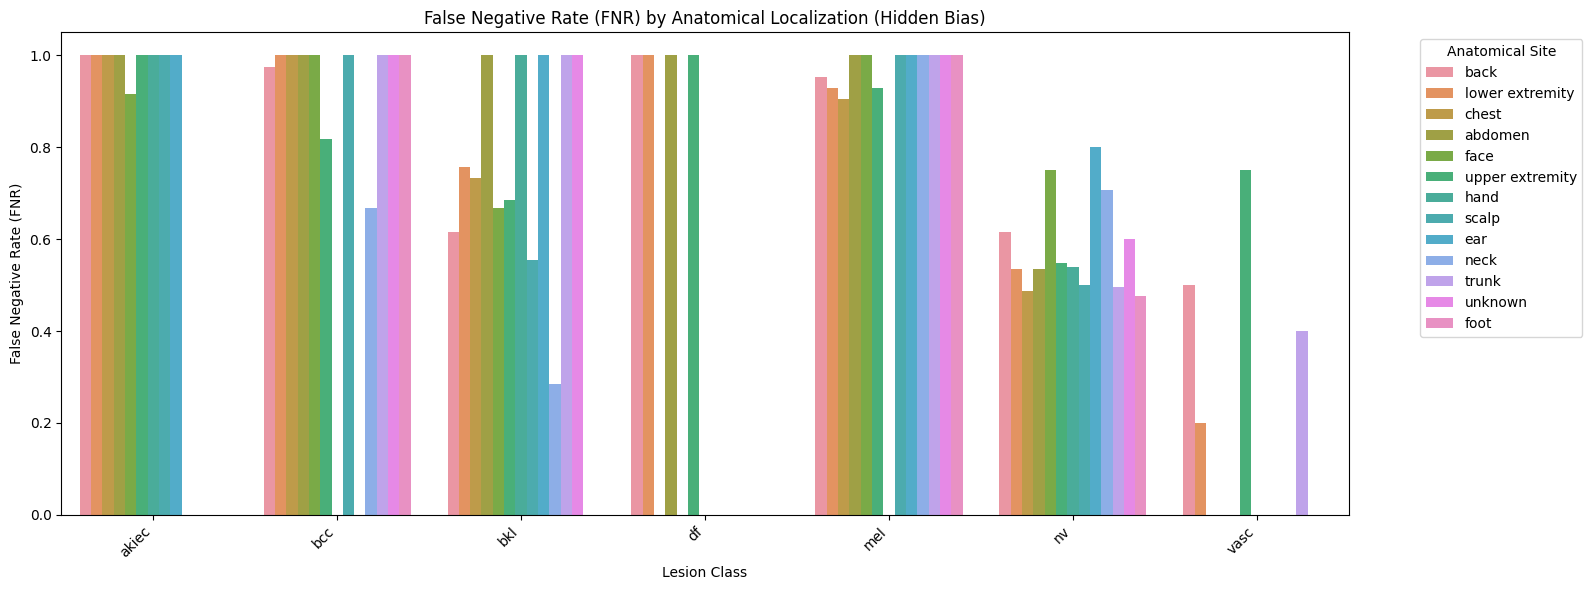

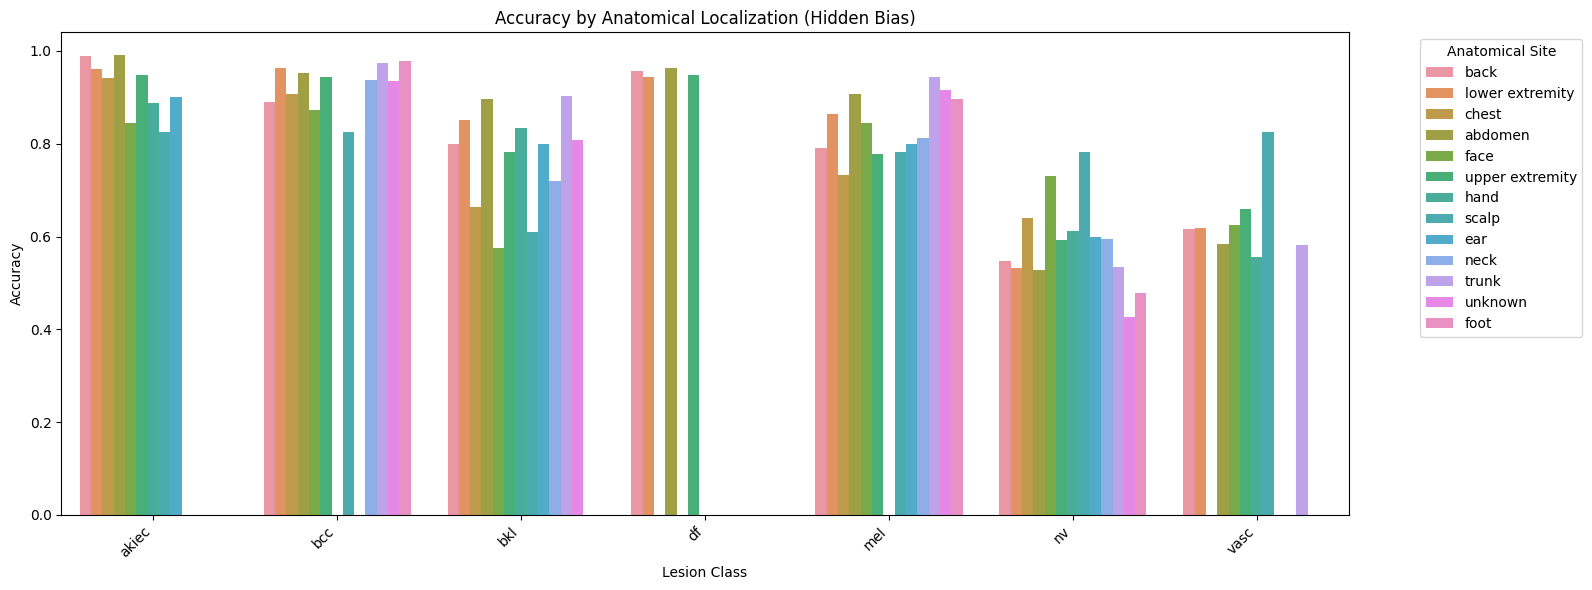

In [12]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# =====================================
# 1. SETUP & PATHS
# =====================================
IMG1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
IMG2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
META = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"

# =====================================
# 2. LOAD & PREPARE METADATA
# =====================================
meta = pd.read_csv(META)

def get_path(image_id):
    p1 = os.path.join(IMG1, f"{image_id}.jpg")
    p2 = os.path.join(IMG2, f"{image_id}.jpg")
    return p1 if os.path.exists(p1) else p2

meta['filename'] = meta['image_id'].apply(get_path)
meta = meta[meta['filename'].apply(os.path.exists)] # Filter for existing files
meta['age'] = meta['age'].fillna(meta['age'].median())
meta['localization'] = meta['localization'].fillna('unknown') # Fill missing localization

# Feature Engineering for Fairness Audit (Age Bins)
meta['age_bin'] = pd.cut(
    meta['age'],
    bins=[-1, 30, 50, 120],
    labels=['<30', '30-50', '>50']
)

# =====================================
# 3. SAMPLE WEIGHTS (Multi-Factor Fairness Weighting)
# =====================================
total = len(meta)
class_counts = meta['dx'].value_counts().to_dict()
class_weights = {
    c: total / (len(class_counts) * n)
    for c, n in class_counts.items()
}

subgroup_wts = {}
for col in ['sex', 'age_bin']:
    freqs = meta[col].value_counts().to_dict()
    subgroup_wts[col] = {
        g: total / (len(freqs) * c)
        for g, c in freqs.items()
    }

meta['sample_weight'] = meta.apply(
    lambda r: class_weights[r['dx']]
              * subgroup_wts['sex'].get(r['sex'], 1.0)
              * subgroup_wts['age_bin'].get(r['age_bin'], 1.0),
    axis=1
)

# =====================================
# 4. SPLIT & GENERATORS
# =====================================
train_df, val_df = train_test_split(
    meta,
    test_size=0.20,
    stratify=meta['dx'],
    random_state=42
)

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='dx', weight_col='sample_weight',
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='dx', weight_col='sample_weight',
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

class_names = list(val_gen.class_indices.keys())
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

# =====================================
# 5. MODEL BUILD & TRAIN (EfficientNetB0)
# =====================================
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training (Simplified for the sake of script completion, typically requires more epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("Starting Initial Training (Feature Extraction)...")
model.fit(train_gen, validation_data=val_gen, epochs=5, callbacks=[early_stopping], verbose=1)

# Fine-tuning (Optional, but often improves results)
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
print("Starting Fine-Tuning...")
model.fit(train_gen, validation_data=val_gen, epochs=5, callbacks=[early_stopping], verbose=1)


# =====================================
# 6. PREDICTION EXTRACTION & DATAFRAME FIX
# =====================================
val_gen.reset()
y_prob = model.predict(val_gen)
y_pred = np.argmax(y_prob, axis=1)
y_true = val_gen.classes

# --- FIX: Ensure 'localization' is included in fair_df ---
fair_df = val_df.reset_index(drop=True).copy()
fair_df['true_label'] = y_true
fair_df['pred_label'] = y_pred
fair_df['prob_max']   = y_prob.max(axis=1)

# Keep all necessary columns, including 'localization'
fair_df = fair_df[['filename', 'dx', 'sex', 'age_bin', 'localization',
                   'true_label', 'pred_label', 'prob_max']]

print("\nFixed fair_df columns:", fair_df.columns.tolist())
print("Fixed fair_df head:\n", fair_df.head())


# =====================================
# 7. FAIRNESS FUNCTION DEFINITION
# =====================================
def compute_class_fairness(df, class_idx, sensitive_feature):
    rows = []
    # FIX: Sensitive feature lookup now works on the fixed fair_df
    for group in df[sensitive_feature].dropna().unique():
        sub = df[df[sensitive_feature] == group]

        y_true = (sub['true_label'] == class_idx).astype(int)
        y_pred = (sub['pred_label'] == class_idx).astype(int)

        if y_true.nunique() < 2:
            continue

        acc = accuracy_score(y_true, y_pred)
        auc = np.nan # Simplified AUC for robustness

        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()

        fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan

        rows.append({
            'group': group,
            'accuracy': acc,
            'auc': auc,
            'fnr': fnr,
            'fpr': fpr
        })

    return pd.DataFrame(rows)


# =====================================
# 8. LOCALIZATION BIAS AUDIT (Experiment 3)
# =====================================
print("\n--- Running Localization Bias Audit (Fairness Beyond Demographics) ---")
localization_results = []
# idx maps to the integer label (0-6)
# cname maps to the string label ('akiec', 'bcc', etc.)
for idx, cname in enumerate(class_names):
    # This call now correctly uses the 'localization' column from fair_df
    loc_df = compute_class_fairness(fair_df, idx, 'localization')
    loc_df['class'] = cname
    loc_df['sensitive_feature'] = 'localization'
    localization_results.append(loc_df)

final_loc_df = pd.concat(localization_results, ignore_index=True)

print("Final Localization Fairness Audit Results:\n", final_loc_df)

# =====================================
# 9. VISUALIZATION
# =====================================

# 9a. FNR by Anatomical Localization
plt.figure(figsize=(16, 6))
sns.barplot(
    data=final_loc_df.dropna(subset=['fnr']), # Drop groups where FNR could not be calculated
    x='class', y='fnr', hue='group'
)
plt.title("False Negative Rate (FNR) by Anatomical Localization (Hidden Bias)")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Lesion Class")
plt.ylabel("False Negative Rate (FNR)")
plt.legend(title="Anatomical Site", bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()


# 9b. Accuracy by Anatomical Localization
plt.figure(figsize=(16, 6))
sns.barplot(
    data=final_loc_df,
    x='class', y='accuracy', hue='group'
)
plt.title("Accuracy by Anatomical Localization (Hidden Bias)")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Lesion Class")
plt.ylabel("Accuracy")
plt.legend(title="Anatomical Site", bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()